In [1]:
#import python classes and packages
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import nltk
from string import punctuation
import os
from Attention import attention #importing attention layer
from sklearn.feature_extraction.text import TfidfVectorizer #loading tfidf vector
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, Model, load_model
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint 
from keras.layers import Bidirectional, LSTM, Conv1D, MaxPooling1D, RepeatVector#loading bidriectional CNN and lstm
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import pickle
from textblob import TextBlob
from nltk.tag import pos_tag

Using TensorFlow backend.
c:\users\shashank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\shashank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\shashank\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
#define object to remove stop words and other text processing
stop_words = set(stopwords.words('english'))
path = "Dataset"
labels = []
X = []
Y = []
features = []

In [3]:
#displaying different authors style found in dataset
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
print(labels)            

['AaronPressman', 'AlanCrosby', 'AlexanderSmith', 'BenjaminKangLim', 'BernardHickey', 'BradDorfman', 'DarrenSchuettler', 'DavidLawder', 'EdnaFernandes', 'EricAuchard', 'FumikoFujisaki', 'GrahamEarnshaw', 'HeatherScoffield', 'JaneMacartney', 'JanLopatka', 'JimGilchrist', 'JoeOrtiz', 'JohnMastrini', 'JonathanBirt', 'JoWinterbottom', 'KarlPenhaul', 'KeithWeir', 'KevinDrawbaugh', 'KevinMorrison', 'KirstinRidley', 'KouroshKarimkhany', 'LydiaZajc', "LynneO'Donnell", 'LynnleyBrowning', 'MarcelMichelson', 'MarkBendeich', 'MartinWolk', 'MatthewBunce', 'MichaelConnor', 'MureDickie', 'NickLouth', 'PatriciaCommins', 'PeterHumphrey', 'PierreTran', 'RobinSidel', 'RogerFillion', 'SamuelPerry', 'SarahDavison', 'ScottHillis', 'SimonCowell', 'TanEeLyn', 'TheresePoletti', 'TimFarrand', 'ToddNissen', 'WilliamKazer']


In [4]:
#function to get each author label as integer for prediction
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [5]:
#define function to clean text by removing stop words and other special symbols
def cleanText(doc):
    tokens = doc.split()
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [6]:
#function to calculate sensitivity
def getSensitivity(text):
    text_blob = TextBlob(text)
    sensitivity = text_blob.sentiment.polarity
    return sensitivity
#function to get dialogue naration ratio
def getNarationRatio(sentences):
    tokens = nltk.word_tokenize(sentences)
    dialogue = []
    narration = []
    for token in tokens:
        if token in ["'", "``"]:
            if token == "'":
                dialogue.append("''")
            else:
                dialogue.append("``")
        elif token in [".", ",", "!", "?"]:
            if dialogue:
                dialogue.append(token)
                narration.append(" ".join(dialogue))
                dialogue = []
            else:
                narration.append(token)
        else:
            dialogue.append(token)
    dialogue_ratio = len(dialogue) / len(narration)
    return dialogue_ratio
#function to get sentence complexity
def getComplexity(sentence):
    vowel = 'aeiouy'
    word_count = 0
    words = nltk.word_tokenize(sentence)
    word_count = len(words)
    words = sentence.lower()
    syllables = 0
    for i in range(len(words)):
        if words[i] in vowel:
            syllables += 1
    complexity = 0.39 * (len(words) / len(nltk.sent_tokenize(sentence))) + 11.8 * (syllables / len(words)) - 15.59
    return complexity
#function to get pronoun, adverb and adjective
def pronouns_adjectives_adverbs(sentence):
    words = nltk.word_tokenize(sentence)
    words = [word for word in words if word not in stop_words]
    tags = pos_tag(words)
    prp = 0
    adjective = 0
    adverb = 0
    for word, tag in tags:
        if tag == 'PRP':
            prp += 1
        elif tag == 'JJ' or tag == 'JJR' or tag == 'JJS':
            adjective += 1
        elif tag == 'RB' or tag == 'RBR' or tag == 'RBS':
            adverb += 1
    return prp, adjective, adverb
#function to get average words and sentences
def avgWordSentences(text):
    sentences = nltk.sent_tokenize(text)
    words_per_sentence = 0
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        words_per_sentence += len(words)       
    if len(sentences) > 0:
        words_per_sentence = words_per_sentence / len(sentences)
    return len(sentences), words_per_sentence

In [7]:
if os.path.exists('model/X.txt.npy'):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
    features = np.load('model/features.npy')
else:
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            with open(root+"/"+directory[j], "r") as file:#read content of each file
                data = file.read()
            file.close()
            label = getLabel(name)#get author label
            data = data.strip().lower()
            avg_sentences, avg_word = avgWordSentences(data)
            sentence_complexity = getComplexity(data)
            naration_ratio = getNarationRatio(data)
            pronoun, adjective, adverb = pronouns_adjectives_adverbs(data)
            content_sensitivity = getSensitivity(data)
            features.append([avg_sentences, avg_word, sentence_complexity, naration_ratio, pronoun, adjective, adverb, content_sensitivity])
            data = cleanText(data)#clean text data
            tokens = nltk.word_tokenize(data)
            tagged = nltk.pos_tag(tokens)#get POS as syntatic information===========================
            tagged = np.asarray(tagged)
            words = tagged[:,0]
            pos = tagged[:,1]
            word = np.concatenate([words, pos])#combine both structural and syntatic data
            word = ' '.join(word)
            X.append(word)#append words and label to X and Y as training data
            Y.append(label)            
    X = np.asarray(X)
    Y = np.asarray(Y)
    features = np.asarray(features)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)    
    np.save("model/features", features)
print("Reuters_50_50 Dataset Loaded")
print("Total author style files loaded : "+str(X.shape[0]))
print("Total authors found in Dataset : "+str(len(np.unique(Y))))

Reuters_50_50 Dataset Loaded
Total author style files loaded : 2500
Total authors found in Dataset : 50


In [8]:
#displaying structural and syntatci process data
print(X[0])

internet may overflowing new technology crime cyberspace still oldfashioned variety national consumers league said wednesday popular scam internet pyramid scheme early investors bogus fund paid deposits later investors league nonprofit consumer advocacy group tracks web scams site set world wide web february called internet fraud watch httpwwwfraudorg site collects reports directly consumers widely praised law enforcement agencies consumers suspect scam internet critical information said jodie bernstein director federal trade commissions bureau consumer protection internet fraud watch major help ftc identifying particular scams infancy may example commission used internet reports shut site run fortuna alliance taken million promising investors could earn month initial deposit instead fortuna kept money commission charged fraud reports leagues site visited times forwarded local state federal authorities secondmostpopular internet scam league said sale bogus internet services custom desi

In [9]:
#convert structural and syntatic data to numeric vector
#defining TF-IDF with Ngram_range as (1,2) to get features normalize word count
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words, use_idf=True, smooth_idf=False, norm=None, decode_error='replace', max_features=776)
X = tfidf_vectorizer.fit_transform(X).toarray()
temp = pd.DataFrame(X, columns=tfidf_vectorizer.get_feature_names_out())
temp

,able,access,according,acquisition,added,adding,agency,ago,agreed,agreement,...,worth,would,wp,year,year ago,years,yen,yet,york,yuan
0,0.000000,3.501036,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,3.168054,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,1.319654,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,7.002072,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,2.639309,0.000000,1.435100,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,2.639309,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.168054,0.000000,0.000000,0.0,0.0,0.0,0.000000,2.783791,0.0,0.0,...,0.0,2.639309,0.000000,4.305300,0.0,1.785262,0.0,0.0,0.0,0.000000
2496,0.000000,0.000000,3.024953,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,1.319654,3.453408,5.740400,0.0,3.570525,0.0,0.0,0.0,0.000000
2497,0.000000,0.000000,3.024953,0.0,0.0,0.0,7.412104,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,4.305300,0.0,0.000000,0.0,0.0,0.0,0.000000
2498,6.336108,0.000000,3.024953,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,6.598272,0.000000,11.480799,0.0,3.570525,0.0,0.0,0.0,4.313187


In [10]:
#normalize, shuffle and split dataset into train and test
X = np.hstack((X, features))
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]
X = np.reshape(X, (X.shape[0], 28, 28))
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("80% dataset will be used for training : "+str(X_train.shape[0]))
print("20% dataset will be used for testing : "+str(X_test.shape[0]))

80% dataset will be used for training : 2000
20% dataset will be used for testing : 500


In [11]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [12]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    global labels
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print(algorithm+' Overall Accuracy  : '+str(a))
    print(algorithm+' Overall Precision : '+str(p))
    print(algorithm+' Overall Recall    : '+str(r))
    print(algorithm+' Overall FSCORE    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(12, 8)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()


LSTM Overall Accuracy  : 96.8
LSTM Overall Precision : 96.82929292929293
LSTM Overall Recall    : 96.56520146520147
LSTM Overall FSCORE    : 96.56251224712929


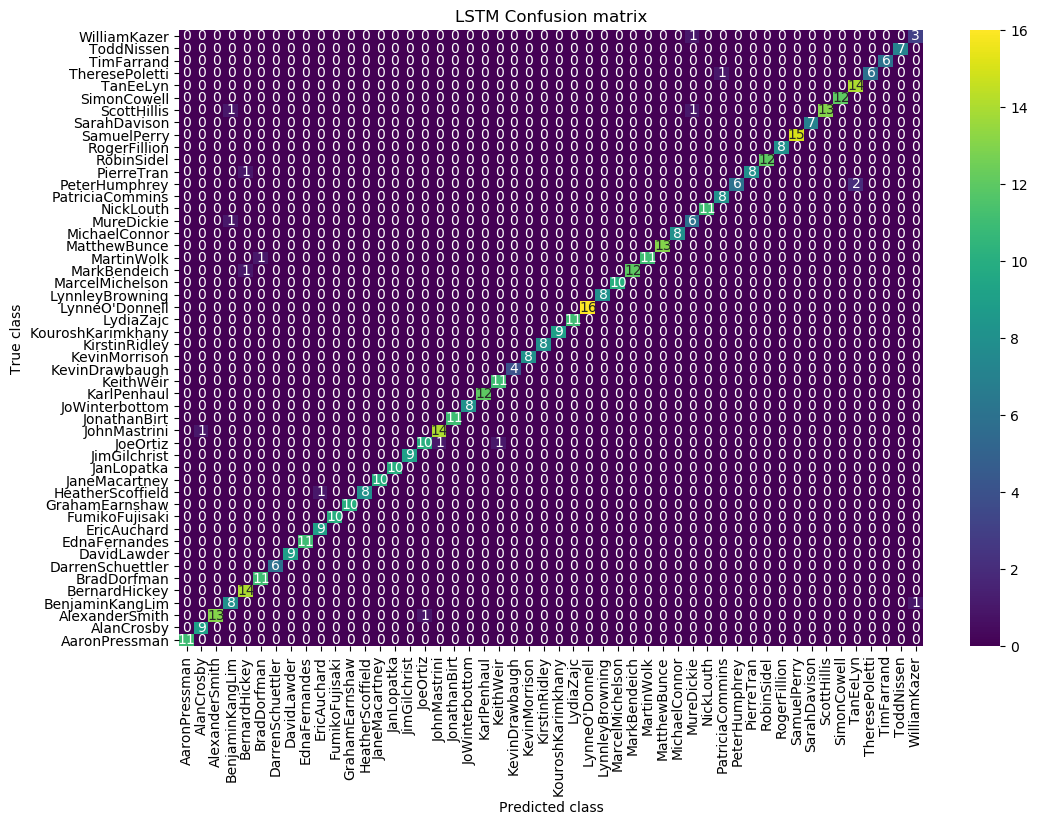

In [13]:
#now train propose LSTM with bidirectional CNN algorithm
lstm_model = Sequential() #defining deep learning sequential object
#adding Bidirectional LSTM layer with 32 filters to filter given input X train data to select relevant features
lstm_model.add(Bidirectional(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#adding dropout layer to remove irrelevant features
lstm_model.add(Dropout(0.2))
#adding another layer
lstm_model.add(Bidirectional(LSTM(32)))#adding bidirectional-GRU layer and peform training on X_train Bert data
lstm_model.add(Dropout(0.2))
#defining output layer for prediction
lstm_model.add(Dense(y_train.shape[1], activation='softmax'))
#compile GRU model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#start training model on train data and perform validation on test data
if os.path.exists("model/lstm_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/lstm_weights.hdf5', verbose = 1, save_best_only = True)
    hist = lstm_model.fit(X_train, y_train, batch_size = 16, epochs = 25, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/lstm_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close() 
else:
    lstm_model = load_model("model/lstm_weights.hdf5")
predict = lstm_model.predict(X_test)#perfrom prediction on test data
predict = np.argmax(predict, axis=1)
target = np.argmax(y_test, axis=1)
calculateMetrics("LSTM", predict, target)

In [14]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["LSTM Algorithm"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,LSTM Algorithm,96.829293,96.565201,96.562512,96.8


In [15]:
def predictAuthorStyle(file_path):
    with open(file_path, "r") as file:
        content = file.read() #read text data from given file
    file.close()
    data = content.strip().lower()#convert text to lower cased and assigned to 'data' varaible
    feature_values = []
    avg_sentences, avg_word = avgWordSentences(data)#get average words and sentences length
    sentence_complexity = getComplexity(data)#get sentence complexity
    naration_ratio = getNarationRatio(data)#get naration ratio
    pronoun, adjective, adverb = pronouns_adjectives_adverbs(data)#get pronoun, adjective and adverb modifier info
    content_sensitivity = getSensitivity(data)#get content sensitivity
    feature_values.append([avg_sentences, avg_word, sentence_complexity, naration_ratio, pronoun, adjective, adverb, content_sensitivity])
    feature_values = np.asarray(feature_values)
    data = cleanText(data) #clean text data
    tokens = nltk.word_tokenize(data)
    tagged = nltk.pos_tag(tokens) #get pos tagging for each word in sentence
    tagged = np.asarray(tagged)
    words = tagged[:,0]
    pos = tagged[:,1]
    word = np.concatenate([words, pos])#combine both structure and syntatic info
    word = ' '.join(word)
    temp = tfidf_vectorizer.transform([word]).toarray()#convert text to vector
    temp = np.hstack((temp, feature_values))
    temp = np.reshape(temp, (temp.shape[0], 28, 28))
    predict = lstm_model.predict(temp)#using lstm predict author from text style
    predict = np.argmax(predict)
    print("Text Data ===> "+content[0:300])
    print()
    print("Author Predicted from Style ====> "+labels[predict])

In [16]:
#call this function with author test file to predict author name
predictAuthorStyle("testFiles/1.txt")

Text Data ===> Beijing's top negotiator with rival Taipei sought on Tuesday to allay Taiwan's fears that China would swallow up the island if Taipei lifts a decades-old ban on direct trade and transport links between the two.
"We feel this kind of strange logic is very ridiculous," Tang Shubei, vice-chairman of th

Author Predicted from Style ====> BenjaminKangLim


In [17]:
#call this function with author test file to predict author name
predictAuthorStyle("testFiles/2.txt")

Text Data ===> China's economy grew by 9.6 percent in the first nine months of 1996, but many urban family incomes are lagging behind, the State Statistical Bureau said on Wednesday.
Chinese industrial output was up, farmers were on their way to a year of record grain harvests and the scourge of inflation had been

Author Predicted from Style ====> MureDickie


In [18]:
#call this function with author test file to predict author name
predictAuthorStyle("testFiles/3.txt")

Text Data ===> The battle between Bill Gates and Larry Ellison over the ballyhooed network computer is getting rougher.
For the past year, Oracle Corp. Chairman Larry Ellison has been evangelizing his vision of a low-cost, diskless PC to access corporate networks and the Internet, a PC without a hefty operating sy

Author Predicted from Style ====> TheresePoletti


In [19]:
#call this function with author test file to predict author name
predictAuthorStyle("testFiles/4.txt")

Text Data ===> Corporate financing for a downtown Detroit sports stadium complex is in place and land acquisition nearly complete, Mayor Dennis Archer said Friday.
"We believe that we are very, very close in making it happen," Archer said at a news conference. "If property has to be taken, by condemnation or emine

Author Predicted from Style ====> BradDorfman


In [20]:
#call this function with author test file to predict author name
predictAuthorStyle("testFiles/7.txt")

Text Data ===> Spirits, pubs and Dunkin' Donuts group Allied Domecq is likely to post a big drop in full-year profits on Tuesday, hit by a 320 million stg loss on the sale of its 50 percent stake in brewer Carlsberg-Tetley (C-T).
Before this exceptional charge, analysts' forecasts for pretax profits range from 560

Author Predicted from Style ====> TimFarrand
